In [2]:
import xarray as xr
import pandas as pd

In [3]:
ds = xr.open_dataset('/Users/doan/MyDrive/share/metclimdata4ML/S-k-means_paper/AM_t_1950_y.nc')

In [4]:
ds['idata']

<xarray.DataArray 'idata' (n_sample: 134, n_dim: 71)> Size: 76kB
[9514 values with dtype=float64]
Dimensions without coordinates: n_sample, n_dim

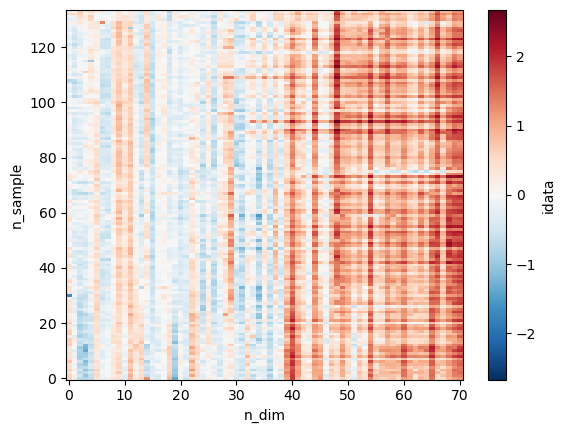

In [5]:
ds['idata'].plot()

In [25]:
df = pd.DataFrame(ds['idata'])
df.index = ds.sts
df = df.T
df.index = ds.year

In [27]:
df.to_csv('Temp_increase_Japan_1950-2020.csv')

<Axes: >

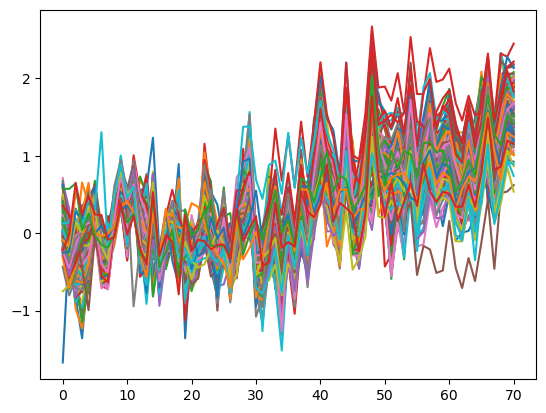

In [16]:
df.plot(legend=False)

In [43]:
dp = xr.open_dataset('/Users/doan/Downloads/PMSL_all.nc')

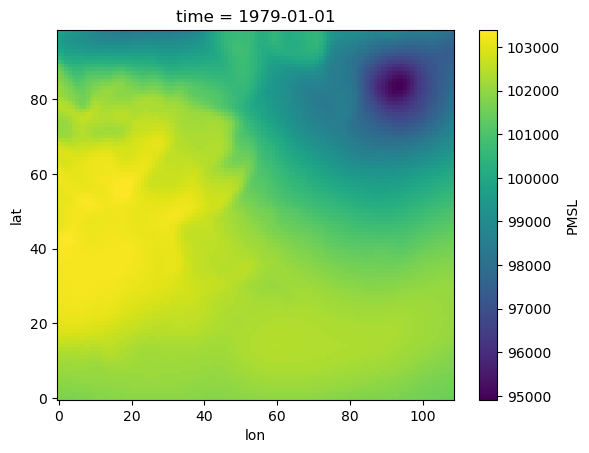

In [44]:
dp.PMSL[0].plot()

In [49]:
# Select one year (e.g., 2010) from the dataset
year_data = dp.sel(time=slice("2010-01-01", "2010-12-31"))
# Update negative longitude values by adding 360 to convert to [0, 360] range
year_data['lon2d'] = year_data.lon2d.where(year_data.lon2d >= 0, year_data.lon2d + 360)


In [52]:
year_data.lon2d.min()

<xarray.DataArray 'lon2d' ()> Size: 4B
array(92.81232, dtype=float32)

In [53]:
# Write to NetCDF3 format
year_data.to_netcdf("SST_2010_data.nc", format="NETCDF3_CLASSIC")

In [56]:
year_data.lon2d

<xarray.DataArray 'lon2d' (lat: 99, lon: 109)> Size: 43kB
array([[116.977264, 117.38919 , 117.8024  , ..., 163.72552 , 164.15063 ,
        164.5747  ],
       [116.84515 , 117.25891 , 117.67395 , ..., 163.83447 , 164.26166 ,
        164.68768 ],
       [116.71173 , 117.12732 , 117.54425 , ..., 163.94458 , 164.37378 ,
        164.80182 ],
       ...,
       [ 93.697815,  94.35553 ,  95.02008 , ..., 183.68176 , 184.4154  ,
        185.14215 ],
       [ 93.258545,  93.91916 ,  94.58676 , ..., 184.07642 , 184.81458 ,
        185.54578 ],
       [ 92.81232 ,  93.4758  ,  94.14642 , ..., 184.47803 , 185.22089 ,
        185.95642 ]], dtype=float32)
Coordinates:
    lat2d    (lat, lon) float32 43kB 17.84 17.96 18.09 ... 59.64 59.43 59.22
    lon2d    (lat, lon) float32 43kB 117.0 117.4 117.8 ... 184.5 185.2 186.0
Dimensions without coordinates: lat, lon

/var/folders/y7/r3_l1bxn4sv6mkmyfgpt9n880000gn/T/ipykernel_16092/746184865.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


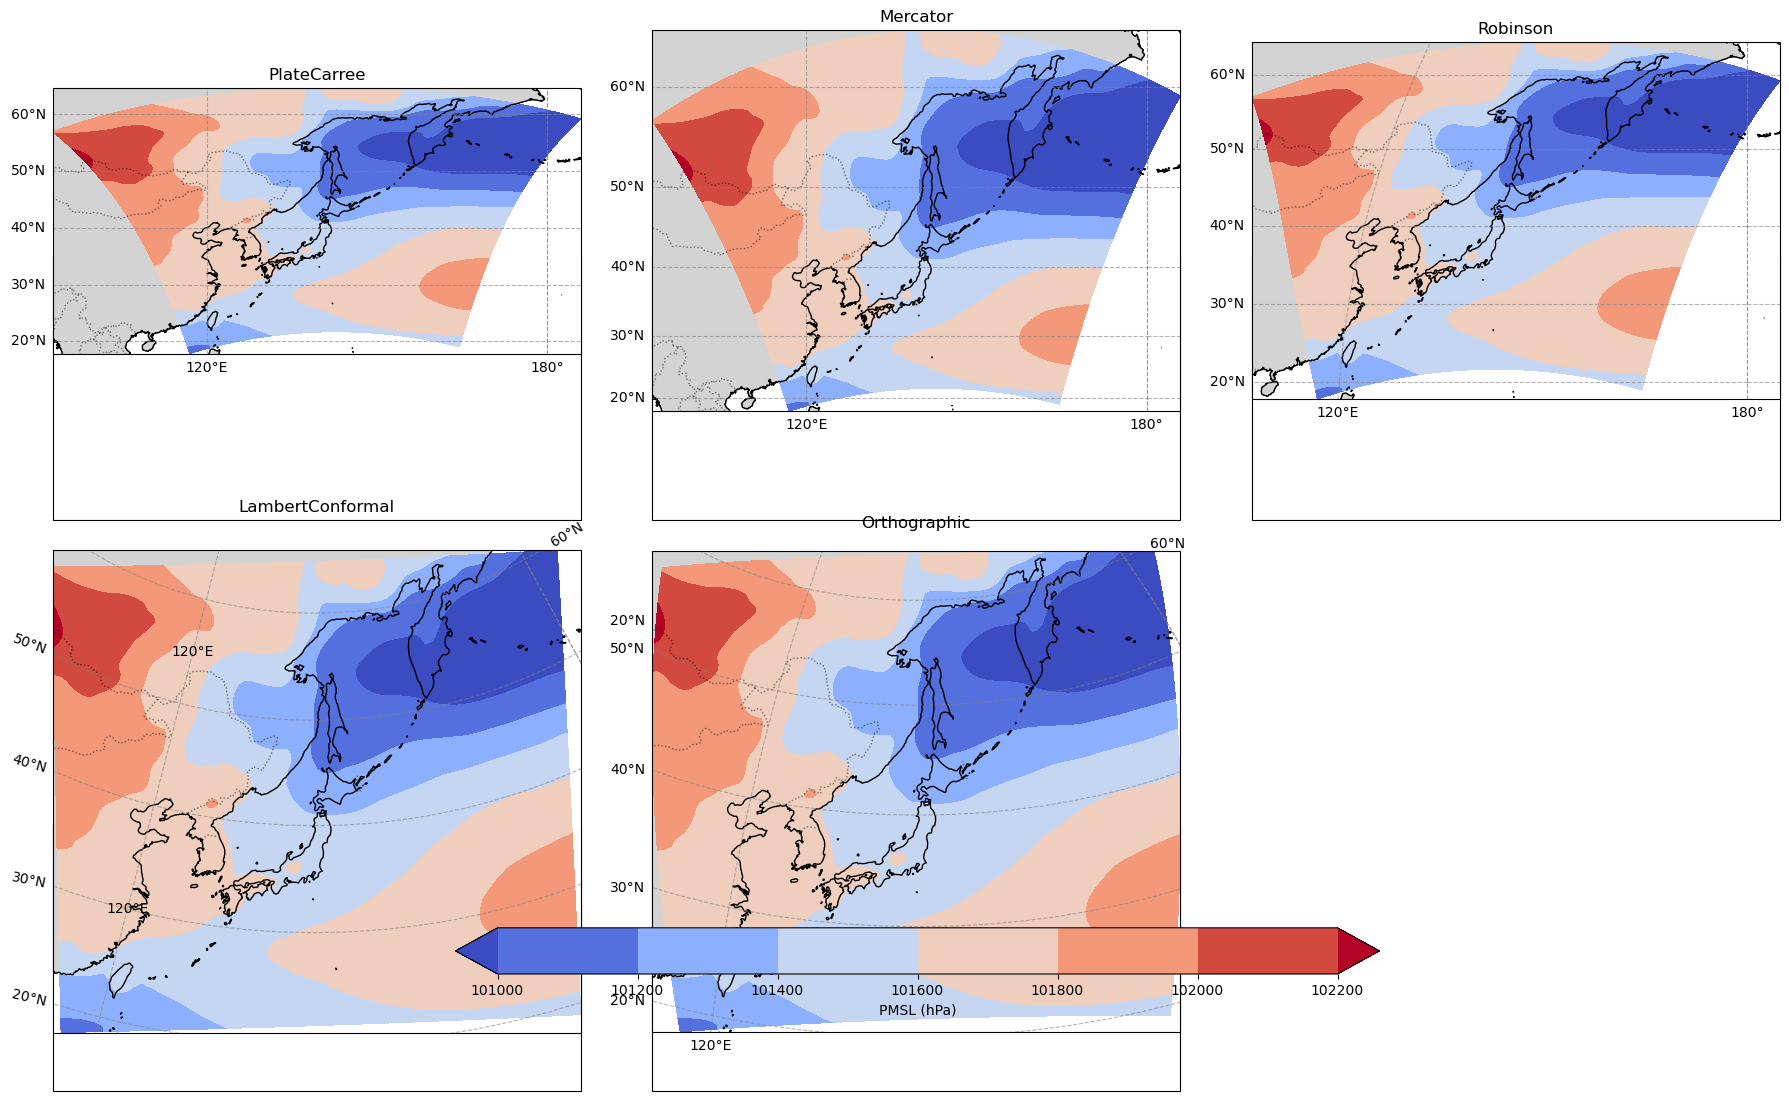

In [61]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# List of projections including Lambert Conformal Conic centered on Japan
projections = [
    ccrs.PlateCarree(central_longitude=180),               # Plate Carree centered on 180°
    ccrs.Mercator(central_longitude=180),                  # Mercator centered on 180°
    ccrs.Robinson(central_longitude=180),                  # Robinson centered on 180°
    ccrs.LambertConformal(central_longitude=140, central_latitude=35, 
                          standard_parallels=(30, 60)),    # Lambert Conformal Conic centered on Japan
    ccrs.Orthographic(central_longitude=140, central_latitude=35)  # Orthographic centered on Japan
]

# Calculate the mean over time to get the annual average PMSL
yearly_mean_pmsl = year_data.PMSL.mean(dim='time')

# Create a figure with optimized spacing and layout
fig, axs = plt.subplots(2, 3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axs = axs.ravel()  # Flatten to easily iterate

for i, projection in enumerate(projections):
    ax = plt.subplot(2, 3, i + 1, projection=projection)  # Create subplot with each projection
    
    # Plot PMSL data on the grid of latitude and longitude, with consistent transform
    contour = ax.contourf(year_data.lon2d, year_data.lat2d, yearly_mean_pmsl, 
                          cmap="coolwarm", transform=ccrs.PlateCarree(), extend="both")
    
    # Add map features for clarity
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', linewidth=0.5)
    
    # Gridlines for geographical orientation
    gl = ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.6)
    gl.top_labels = gl.right_labels = False  # Remove labels on top and right to reduce clutter
    
    # Set the title to the name of the projection for clarity
    ax.set_title(projection.__class__.__name__)

# Add a shared color bar for all subplots
cbar = fig.colorbar(contour, ax=axs, orientation="horizontal", pad=0.1, fraction=0.05, shrink=0.8)
cbar.set_label("PMSL (hPa)")

# Remove the last empty subplot (if using a 2x3 layout)
fig.delaxes(axs[-1])

# Adjust layout and show plot
plt.tight_layout()
plt.show()
